This is a notebook to plot the aspect ratios of all pseduo_labels and its corresponding ground truths. 

In [1]:
import sys
import os

# Add the src directory to the Python path
sys.path.append(os.path.abspath(".."))

In [2]:
import os
from av2.datasets.sensor.av2_sensor_dataloader import AV2SensorDataLoader
from pathlib import Path
from av2.structures.sweep import Sweep
from prototype_utils import (
    filter_gt_labels_by_category,
    extract_face_corners,
    filter_cuboids_by_roi,
    filter_roi,
    bboxes_df_to_numpy_corners)
import numpy as np
from scipy.stats import gaussian_kde
import matplotlib.pyplot as plt
import pandas as pd
from av2.structures.cuboid import  CuboidList
from config import CONFIG

[Warning] Since Open3D 0.15, installing Open3D via conda is deprecated. Please re-install Open3D via: `pip install open3d -U`.
Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [3]:
home = os.path.join(os.path.expanduser('~'))

dataset_path = Path(os.path.join(home, "dataset", "av2", "train"))

av2 = AV2SensorDataLoader(data_dir=dataset_path, labels_dir=dataset_path)

scene_idx = 1
frame_idx = 0

scene_id = av2.get_log_ids()[scene_idx]
print(f"scene_id: {scene_id}")
frame_id = av2.get_ordered_log_lidar_timestamps(scene_id)[frame_idx]
print(f"frame_id: {frame_id}")
frame_path = av2.get_lidar_fpath_at_lidar_timestamp(scene_id, frame_id)
print(f"frame_path: {frame_path}")

points = Sweep.from_feather(frame_path).xyz

INFO - 2025-01-17 14:21:18,195 - synchronization_database - Building SynchronizationDB


scene_id: 01bb304d-7bd8-35f8-bbef-7086b688e35e
frame_id: 315968867659956000
frame_path: /home/ravi.kumar/dataset/av2/train/01bb304d-7bd8-35f8-bbef-7086b688e35e/sensors/lidar/315968867659956000.feather


In [4]:
if CONFIG['ROI']:
    ps_path = os.path.join(home, *CONFIG['FILTERED_BBOX_FILE_PATHS']['ROI'])
else:
    ps_path = os.path.join(home, *CONFIG['BBOX_FILE_PATHS']['FULL_RANGE'])


In [14]:
ps_scene_path = os.path.join(ps_path, os.listdir(ps_path)[scene_idx])
ps_frame_path = os.path.join(ps_scene_path, os.listdir(ps_scene_path)[frame_idx])
ps_label_03 = pd.read_feather(os.path.join(ps_frame_path, "iou_0.3_.feather"))
ps_label_05 = pd.read_feather(os.path.join(ps_frame_path, "iou_0.5_.feather"))
# ps_labels_df = pd.read_feather(ps_frame_path)
# ps_labels_df.head()

In [15]:
def get_all_dataframes(ps_base_path: str):
    main_lst = []
    
    for scene in os.listdir(ps_base_path):
        ps_scene_path = os.path.join(ps_base_path, scene)
        
        for frame in os.listdir(ps_scene_path):
            ps_frame_path = os.path.join(ps_scene_path, frame)
            ps_labels_03_df = pd.read_feather(os.path.join(ps_frame_path, "iou_0.3_.feather"))
            ps_labels_05_df = pd.read_feather(os.path.join(ps_frame_path, "iou_0.5_.feather"))
            elem = {"scene_id": scene, "frame_id": frame, "data_0.3": ps_labels_03_df, "data_0.5": ps_labels_05_df}
            main_lst.append(elem)
    
    return main_lst


from typing import List, Dict
def get_ps_aspect_ratios_and_areas(lst_of_dicts: List[Dict]):
    aspect_ratio_lst_03 = []
    area_lst_03 = []
    aspect_ratio_lst_05 = []
    area_lst_05 = []
    for idx, elem in enumerate(lst_of_dicts):
        scene_id, frame_id, df_03, df_05 = elem["scene_id"], elem["frame_id"], elem["data_0.3"], elem['data_0.5']
        df_03['area'] = df_03['box_length'] * df_03['box_width']
        df_03['aspect_ratio'] = df_03['box_width'] / df_03['box_length']
        
        df_05['area'] = df_05['box_length'] * df_05['box_width']
        df_05['aspect_ratio'] = df_05['box_width'] / df_05['box_length']

        aspect_ratio_lst_03.extend(df_03['aspect_ratio'].tolist())
        area_lst_03.extend(df_03['area'].tolist())
        
        aspect_ratio_lst_05.extend(df_05['aspect_ratio'].tolist())
        area_lst_05.extend(df_05['area'].tolist())
        
    return aspect_ratio_lst_03, area_lst_03, aspect_ratio_lst_05, area_lst_05

In [16]:
import numpy as np
from scipy.stats import gaussian_kde
import matplotlib.pyplot as plt

def plot_kde2(aspect_ratios,x_label="Aspect Ratio", title="Aspect Ratios of GT Cuboids (KDE)"):
    """
    Plots a continuous KDE (Kernel Density Estimate) graph for the given aspect ratios using scipy and matplotlib.
    Also calculates and displays the mean, median, and standard deviation on the plot.
    
    Parameters:
    - aspect_ratios: List of aspect ratios to plot.
    - title: Title of the plot (default is 'Aspect Ratios of GT Cuboids (KDE)').
    """
    # Calculate statistics
    mean_value = np.mean(aspect_ratios)
    median_value = np.median(aspect_ratios)
    std_dev = np.std(aspect_ratios)
    
    # Calculate KDE
    kde = gaussian_kde(aspect_ratios)
    x = np.linspace(min(aspect_ratios), max(aspect_ratios), 100)
    y = kde(x)
    
    # Plot the KDE
    plt.plot(x, y, label="KDE", linewidth=2)
    plt.fill_between(x, y, alpha=0.3)  # Add shading under the curve
    plt.xlabel(x_label)
    plt.ylabel("Density")
    plt.title(title)
    
    # Add statistics as text on the plot
    text_str = (f"Mean: {mean_value:.4f}\n"
                f"Median: {median_value:.4f}\n"
                f"Std Dev: {std_dev:.4f}")
    plt.text(0.95, 0.95, text_str, transform=plt.gca().transAxes,
             fontsize=10, verticalalignment='top', horizontalalignment='right',
             bbox=dict(facecolor='white', alpha=0.8, edgecolor='black'))

    plt.show()
    
    
def plot_kde3(aspect_ratios, x_label="Aspect Ratio", title="Aspect Ratios of GT Cuboids (KDE)", xlim=(0, 10)):
    """
    Plots a continuous KDE (Kernel Density Estimate) graph for the given aspect ratios using scipy and matplotlib.
    Also calculates and displays the mean, median, and standard deviation on the plot.

    Parameters:
    - aspect_ratios: List of aspect ratios to plot.
    - title: Title of the plot (default is 'Aspect Ratios of GT Cuboids (KDE)').
    """
    # Calculate statistics
    mean_value = np.mean(aspect_ratios)
    median_value = np.median(aspect_ratios)
    std_dev = np.std(aspect_ratios)
    minimum = np.min(aspect_ratios) 
    maximum = np.max(aspect_ratios)
    # Calculate KDE
    kde = gaussian_kde(aspect_ratios)
    x = np.linspace(min(aspect_ratios), max(aspect_ratios), 100)
    y = kde(x)

    # Plot the KDE
    plt.plot(x, y, label="KDE", linewidth=2)
    plt.fill_between(x, y, alpha=0.3)  # Add shading under the curve
    plt.xlabel(x_label)
    plt.ylabel("Density")
    plt.title(title)
    
    # Set x-axis limit to focus on the range 0-5
    plt.xlim(xlim)

    # Add statistics as text on the plot
    text_str = (f"Mean: {mean_value:.4f}\n"
                f"Median: {median_value:.4f}\n"
                f"Std Dev: {std_dev:.4f}\n"
                f"Minimum: {minimum:.4f}\n"
                f"Maximum: {maximum:.4f}")
    plt.text(0.95, 0.95, text_str, transform=plt.gca().transAxes,
             fontsize=10, verticalalignment='top', horizontalalignment='right',
             bbox=dict(facecolor='white', alpha=0.8, edgecolor='black'))

    plt.show()

In [18]:
lst_of_dicts = get_all_dataframes(ps_path)
aspect_ratios_03, areas_03, aspect_ratios_05, areas_05  = get_ps_aspect_ratios_and_areas(lst_of_dicts)


# ps_corners_calculated = calc_aspect_ratio_and_area(ps_corners_all)
# ps_aspect_ratios = [cuboid["aspect_ratio"] for cuboid in ps_corners_calculated]
# ps_areas = [cuboid["area"] for cuboid in ps_corners_calculated]

In [20]:
# clean up  ps_aspect_ratios from any NaNs or infs
ps_aspect_ratios_03 = np.array(aspect_ratios_03)
ps_aspect_ratios_03 = ps_aspect_ratios_03[~np.isnan(ps_aspect_ratios_03)]
ps_aspect_ratios_03 = ps_aspect_ratios_03[~np.isinf(ps_aspect_ratios_03)]
ps_aspect_ratios_03 = ps_aspect_ratios_03.tolist()

ps_aspect_ratios_05 = np.array(aspect_ratios_05)
ps_aspect_ratios_05 = ps_aspect_ratios_05[~np.isnan(ps_aspect_ratios_05)]
ps_aspect_ratios_05 = ps_aspect_ratios_05[~np.isinf(ps_aspect_ratios_05)]
ps_aspect_ratios_05 = ps_aspect_ratios_05.tolist()

In [21]:
# check whether it has NaNs or infs
print(type(ps_aspect_ratios_03))
print(np.isnan(ps_aspect_ratios_03).any())
print(np.isinf(ps_aspect_ratios_03).any())

print(type(ps_aspect_ratios_05))
print(np.isnan(ps_aspect_ratios_05).any())
print(np.isinf(ps_aspect_ratios_05).any())

<class 'list'>
False
False
<class 'list'>
False
False


In [22]:
ps_areas_03 = areas_03
print(type(ps_areas_03))
print(np.isnan(ps_areas_03).any())
print(np.isinf(ps_areas_03).any())

<class 'list'>
False
False


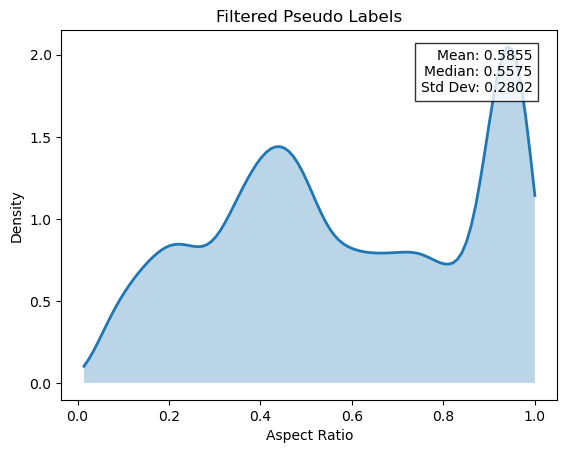

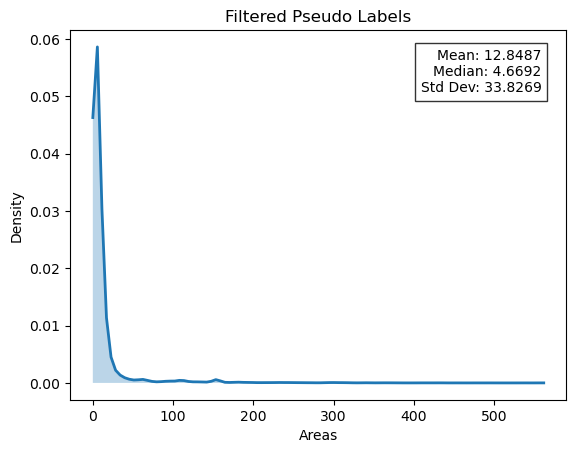

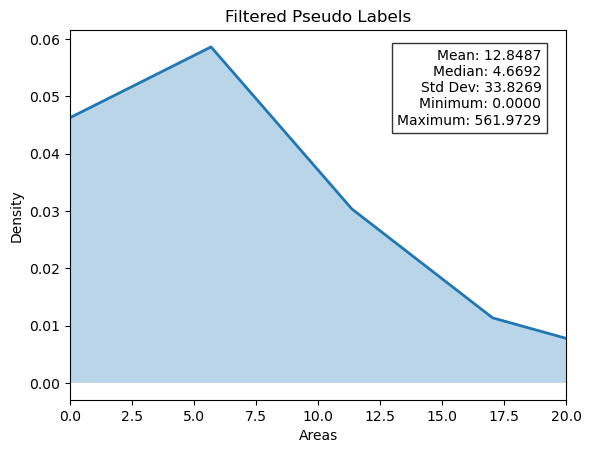

In [29]:
plot_kde2(ps_aspect_ratios_03, title="Filtered Pseudo Labels")
plot_kde2(ps_areas_03,x_label="Areas", title="Filtered Pseudo Labels")
plot_kde3(ps_areas_03,x_label="Areas", title="Filtered Pseudo Labels", xlim=(0, 20))

In [26]:
print(len(areas_03))
print(len(aspect_ratios_03))

26387
26387


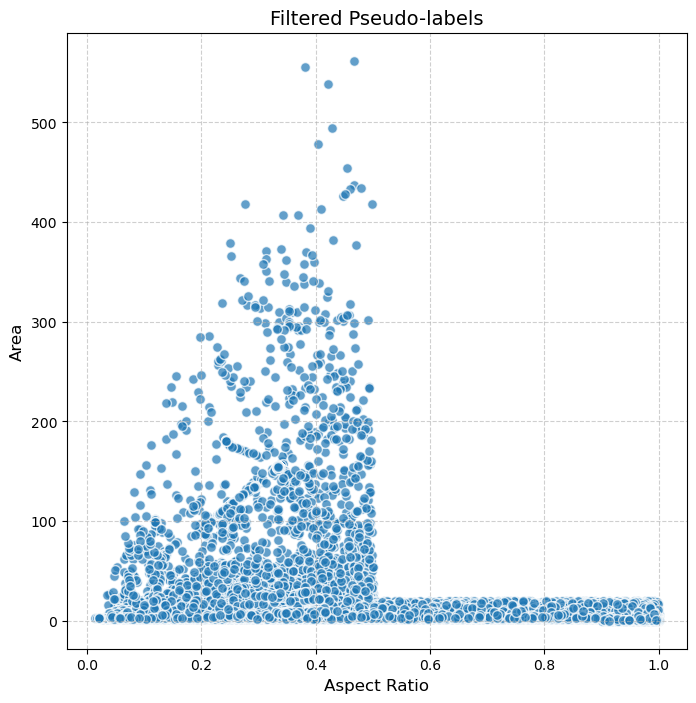

In [28]:
import matplotlib.pyplot as plt
import numpy as np

def plot_area_vs_aspect_ratio(aspect_ratio, area):
    """
    Plots a scatter plot of Area vs Aspect Ratio.

    Parameters:
        aspect_ratio (list or numpy.ndarray): List or array of aspect ratio values.
        area (list or numpy.ndarray): List or array of area values.
    """
    if not isinstance(aspect_ratio, (list, np.ndarray)) or not isinstance(area, (list, np.ndarray)):
        raise ValueError("Both aspect_ratio and area must be lists or numpy arrays.")

    if len(aspect_ratio) != len(area):
        raise ValueError("aspect_ratio and area must have the same length.")

    plt.figure(figsize=(8, 8))
    plt.scatter(aspect_ratio, area, alpha=0.7, edgecolors='w', s=50)

    plt.title("Filtered Pseudo-labels", fontsize=14)
    plt.xlabel("Aspect Ratio", fontsize=12)
    plt.ylabel("Area", fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()

plot_area_vs_aspect_ratio(aspect_ratios_03, areas_03)